
# Part 1



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import Sequence, TypeVar, Callable
import itertools as itr
import functools as ft
from sympy.solvers import solve
from sympy import Symbol


In [3]:
T = TypeVar('T')
Seq = Sequence[T] | np.ndarray

pow = np.power
fact = np.math.factorial
def sin_maclaurin_term(x: float, k: int) -> float:
    n = 2*k + 1
    return ( 1 - (2*(k & 0b1)) ) * ( (pow(x,n)) / fact(n) )

npsum = np.sum
fromiter = np.fromiter
f64 = np.float64
def sin_approx_power_series(x: float, n: int) -> float:
    return npsum(fromiter(
        (sin_maclaurin_term(x, k) for k in range(n+1)),
        dtype=f64
    ))


In [4]:
def compare_sin(xs: Seq[float], n_range: Seq[int]) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots()
    for n in n_range:
        ax.plot(
            xs,
            [sin_approx_power_series(x, n) for x in xs],
            label=f'n={n}'
        )
    return fig, ax

def show_compare_sin() -> None:
    xs = np.linspace(-3*np.pi, 3*np.pi, 75)
    _, ax = compare_sin(xs, (0, 1, 2, 3, 5, 10, 12))
    ax.plot(xs, np.sin(xs), label='sin(x)')
    ax.set_ylim(-2, 2)
    ax.legend()
    plt.show()

def ifilter(l: Seq[T], il: Seq[int]) -> Seq[T]:
    return [l[i] for i in il]

def plot_error(xs: Seq[float], n_range: Seq[int], log_base: float = 10) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots()
    for x in xs:
        term_sums = (sin_approx_power_series(x, n) for n in n_range)
        term_errs = [abs(np.sin(x) - s) for s in term_sums]
        nz_indices = [i for i in range(len(term_errs)) if term_errs[i] != 0]
        term_errs_log = [math.log(term_errs[i], log_base) for i in nz_indices]
        ax.plot(ifilter(n_range, nz_indices), term_errs_log, label=f'x={x:.4f}')
    return fig, ax

Text(0, 0.5, 'log absolute error')

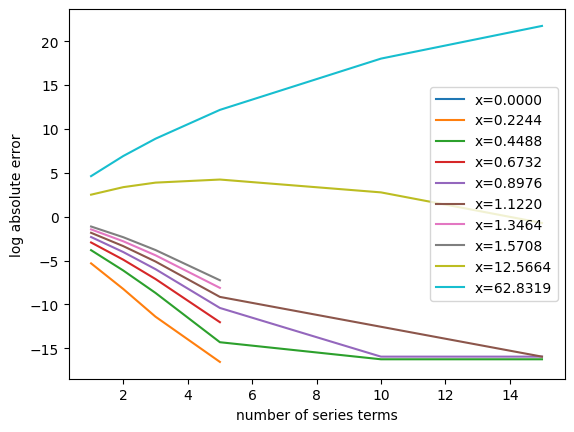

In [5]:
xs = list(np.linspace(0, 0.5*np.pi, 8)) + [4*np.pi, 20*np.pi]
ns = (1, 2, 3, 5, 10, 15)
_, ax = plot_error(xs, ns)
ax.legend()
ax.set_xlabel('number of series terms')
ax.set_ylabel('log absolute error')

Note that "missing" values in the above plot represent error values of zero. These are cut off to prevent logarithm domain errors.


The absolute error represents the absolute value of the *remainder*, $\lvert R_n(x)\rvert$. Thus, the average slope of the logarithm of this value over $n$ represents the order of convergence.

In [6]:
def reduce_argument(x: float) -> tuple[int, float]:
    s = x<0
    t = abs(x) % (2*np.pi)
    if t > np.pi:
        s = not s
        t = 2*np.pi - t
    if t > np.pi/2:
        t = np.pi - t
    return -1 if s else 1, t

def sin_approx_power_series_reduced(x: float, n: int) -> float:
    s, t = reduce_argument(x)
    return s*sin_approx_power_series(t, n)

def sin_approx_power_series_reduced_double_angle(x: float, n: int, c: int = 1) -> float:
    s, t = reduce_argument(x)
    z = t
    for _ in range(c):
        z = z/2
    sinz = sin_approx_power_series(z, n)
    for _ in range(c):
        sinz = 2*sinz * math.sqrt(1 - sinz**2)
    return s*sinz

In [7]:
def get_sin_approx_reduced_double_angle(c: int) -> Callable:
    return lambda x,n,c=c: sin_approx_power_series_reduced_double_angle(x,n,c)

In [8]:
def plot_error_reduced(ax: plt.Axes, f: Callable, exact: Callable, xs: Seq[float], n_range: Seq[int]):
    for x in xs:
        term_sums = (f(x, n) for n in n_range)
        term_errs = [abs(exact(x) - e) for e in term_sums]
        term_errs_filtered = itr.takewhile(lambda e: e != 0, term_errs)
        term_errs_log = [math.log(e, 10) for e in term_errs_filtered]
        ax.plot(n_range[:len(term_errs_log)], term_errs_log, label=f'{x:.4f}')

def sin_main(func: Callable):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)
    (ax1, ax2, ax3, ax4) = axes
    xs = np.linspace(0.01, 2*np.pi, 15)
    xs = [0.01, 0.05, 0.25, 0.5, 0.75, 0.5*np.pi, 0.75*np.pi, np.pi+0.01, 2*np.pi+0.01]
    n_range = list(range(12))
    func( ax1, sin_approx_power_series_reduced, np.sin, xs, n_range )
    func( ax2, get_sin_approx_reduced_double_angle(2), np.sin, xs, n_range )
    func( ax3, get_sin_approx_reduced_double_angle(5), np.sin, xs, n_range )
    func( ax4, get_sin_approx_reduced_double_angle(7), np.sin, xs, n_range )
    for ax in axes:
        ax.legend()
    plt.show()


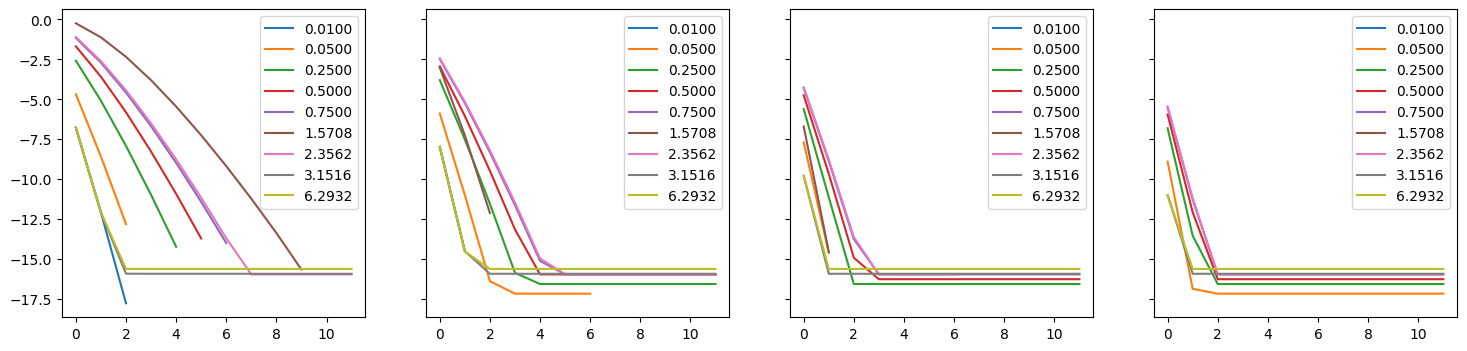

In [9]:
sin_main(func=plot_error_reduced)

In the above plot, different argument reductions are used. The first (leftmost) figure represents simply reducing the argument within the range
$$
0 \leq x < \frac{\pi}{2}
$$
which obviously requires essentially no extra work by virtue of trigonometric symmetries. Nevertheless, it clearly gives better results than the former method as the input to the series approximation is much closer to it's approximation center.

The remaining three plots add an additional reduction step through the double angle formula for the sine:
$$
\sin x = 2 \sin \left(\frac{x}{2}\right) \sqrt{ 1 - \sin^2 \left(\frac{x}{2}\right)}
$$
which can be repeated. The second plot applies this twice, the third applies it five times, and the last applies it 7 times.

In [10]:
def logp1_term(x: float, k: int) -> float:
    return ( -1 + (2*(k & 0b1)) ) * ( (pow(x,k)) / k )

def logp1_approx_power_series(x: float, n: int) -> float:
    return npsum(fromiter(
        (logp1_term(x, k) for k in range(1, n+1)),
        dtype=f64
    ))

In [11]:

def compare_log(xs: Seq[float], n_range: Seq[int]) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots()
    for n in n_range:
        ax.plot(
            xs,
            [logp1_approx_power_series(x-1, n) for x in xs],
            label=f'n={n}'
        )
    return fig, ax

def show_compare_log() -> None:
    xs = np.linspace(0.1, 5.0, 20)
    _, ax = compare_log(xs, (1, 2, 3, 5, 10, 12))
    ax.plot(xs, np.log(xs), label='log(x)')
    ax.set_ylim(-1, 10)
    ax.legend()
    ax.set_title('log(x) approximations')
    plt.show()

def plot_error_log(xs: Seq[float], n_range: Seq[int]) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots()
    for x in xs:
        term_sums = (logp1_approx_power_series(x-1, n) for n in n_range)
        term_errs = [abs(np.log(x) - s) for s in term_sums]
        term_errs_filtered = itr.takewhile(lambda e: e != 0, term_errs)
        term_errs_log = [math.log(e, 10) for e in term_errs_filtered]
        ax.plot(n_range[:len(term_errs_log)], term_errs_log, label=f'x={x:.4f}')
    return fig, ax

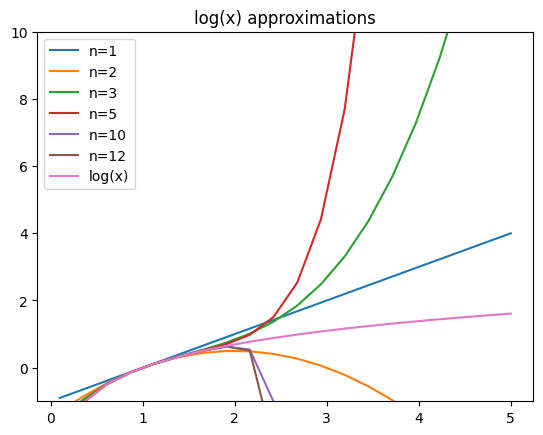

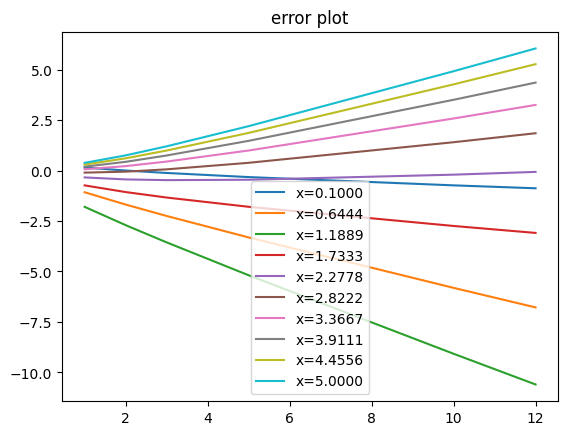

In [12]:
show_compare_log()
xs = np.linspace(0.1, 5.0, 10)
_, ax = plot_error_log(
    xs,
    (1,2,3,5,10,12)
)
ax.legend()
ax.set_title('error plot')
plt.show()

Below, we use the reduction
$$
\begin{align*}
&\phantom{=.} \log(1+x) \\[2mm]
&= 2 \log \sqrt{1+x} \\[2mm]
&= 2 \log \left( 1 + \frac{x}{1+ \sqrt{1+x}} \right)
\end{align*}
$$
before approximating with the power series.

In [13]:
def log_reduced(x: float, n: int, c: int) -> float:
    z = x-1
    for _ in range(c):
        z = z/(1 + math.sqrt(1+z))
    logzp1 = logp1_approx_power_series(z, n)
    for _ in range(c):
        logzp1 = 2*logzp1
    return logzp1

def get_log_reduced(c: int) -> Callable:
    return lambda x,n,c=c: log_reduced(x, n, c)

In [14]:
def log_main(func: Callable):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)
    (ax1, ax2, ax3, ax4) = axes
    xs = np.linspace(0.01, 5, 10)
    n_range = list(range(12))
    func( ax1, get_log_reduced(1), np.log, xs, n_range )
    func( ax2, get_log_reduced(3), np.log, xs, n_range )
    func( ax3, get_log_reduced(7), np.log, xs, n_range )
    func( ax4, get_log_reduced(15), np.log, xs, n_range )
    for ax in axes:
        ax.legend()
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('number of series terms')
    plt.ylabel('log absolute error')

    plt.show()

Below, convergence plots are presented with varying argument reduction repetitions.

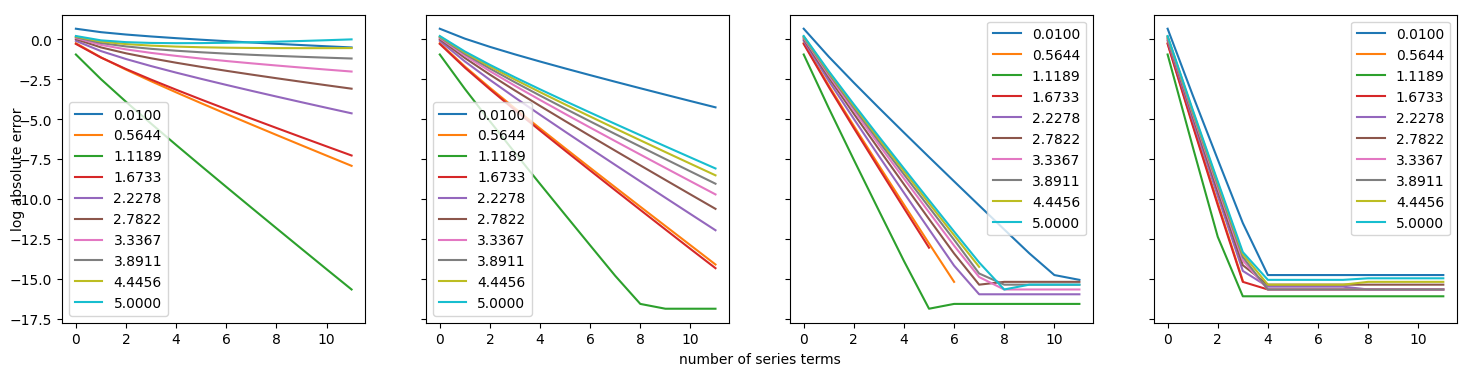

In [15]:
log_main(plot_error_reduced)

$$
$$

In [16]:
def gregory_log_term(x: float, n: int) -> float:
    k = 2*n + 1
    return pow(x, k) / k

def gregory_log_partial_sum(x: float, n: int) -> float:
    return 2*npsum(fromiter(
        (gregory_log_term(x, k) for k in range(n+1)),
        dtype=f64
    ))

# Note: obviously, automatic symbolic solvers are expensive
# This is used just to automate the testing process. In practice
# this would be solved by hand beforehand, since we prescribe
# a certain amount of reductions.
x_symbol = Symbol('x_symbol')
def log_reduced_gregory(x: float, n: int, c: int) -> float:
    z = x-1
    for _ in range(c):
        z = z/(1 + math.sqrt(1+z))
    arg = solve( ((1+x_symbol)/(1-x_symbol))-(z+1), x_symbol )
    logzp1 = gregory_log_partial_sum(arg, n)
    for _ in range(c):
        logzp1 = 2*logzp1
    return logzp1

In [17]:
def show_converge_speed(ax: plt.Axes, f: Callable, n_range: Seq[int], label: str | None = None):
    log3 = np.log(3)
    errs = [abs(log3 - f(n)) for n in n_range]
    ax.plot(list(n_range), errs, label = label)

In the below code, notice that the `"gregory's series (no reductions)"` line uses `0.5` directly, which corresponds to solving for $x$ in the Gregory series expansion for the $\log$:
$$
\begin{align*}
&\phantom{\implies} 3 = \frac{1+x}{1-x} \\[2mm]
&\implies x = \frac{1}{2}
\end{align*}
$$
The other ones that apply this series expansion (which reduce the argument before applying the expansion), for testing purposes, use a symbolic solver to find $x$.

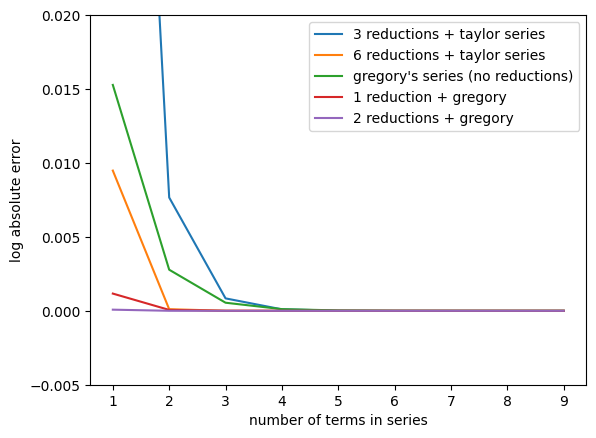

In [18]:
fig, ax = plt.subplots()
ns = range(1,10)
# ft.partial just binds arguments and returns a function that 'remembers' the bound arguments
show_converge_speed(ax, ft.partial(log_reduced, 3, c=3), ns, label='3 reductions + taylor series')
show_converge_speed(ax, ft.partial(log_reduced, 3, c=6), ns, label='6 reductions + taylor series')
show_converge_speed(ax, ft.partial(gregory_log_partial_sum, 0.5), ns, label="gregory's series (no reductions)")
show_converge_speed(ax, ft.partial(log_reduced_gregory, 3, c=1), ns, label='1 reduction + gregory')
show_converge_speed(ax, ft.partial(log_reduced_gregory, 3, c=2), ns, label='2 reductions + gregory')
ax.set_ylim(-0.005, 0.02)
ax.set_xlabel('number of terms in series')
ax.set_ylabel('log absolute error')
ax.legend()

The above plot shows different approximations of $\ln 3$. It clearly shows the fast convergence of using only few argument reductions, and then applying James Gregory's series expansion (as seen in the power series notes):
$$
\frac{1}{2} \log \frac{1+x}{1-x} = \sum_{n=0}^{\infty} \frac{x^{2n+1}}{2n+1}
$$

# Part 2

In [19]:
def goldschmidt_method(b: float, n: int, z_init: float | None = None) -> float:
    A = -0.5
    B = 1.5
    z: float
    if z_init is None:
        z = A*b + B
    else:
        z = z_init
    y = b
    for i in range(n):
        y = y*z
        b = b*z*z
        z = A*b + B
    return y

# i'm lazy
gm = goldschmidt_method

def heron_method(a: float, n: int, x_init: float | None = None) -> float:
    if x_init is None:
        x = a
    else:
        x = x_init
    for i in range(n):
        x = 0.5*(x + a/x)
    return x

In [20]:
def perform_test(x: float, n: int) -> None:
    print(f'--- {x=} ---')
    print(f'Exact: {math.sqrt(x)}')
    print(f'Goldschmidt: {gm(x, n)}')
    print(f'Heron: {heron_method(x, n)}')
    print('\n')


perform_test(2, 15)
perform_test(2.5, 15)

--- x=2 ---
Exact: 1.4142135623730951
Goldschmidt: 1.4142135623730951
Heron: 1.414213562373095


--- x=2.5 ---
Exact: 1.5811388300841898
Goldschmidt: 1.58113883008419
Heron: 1.5811388300841895




In the example below, we have a clear example of the self-correcting nature of Heron's method, and lack thereof in the Goldschmidt version.

With the naive initial estimate
$$
k_0 = \frac{3 - b_0}{2}
$$
it can be observed that the Goldschmidt iteration diverges.

However when we provide a better initial estimate, it converges.

In [21]:
perform_test(6, 30)

print(
        f'Goldschimdt with exact initial estimate: '
        f'{gm(6, 30, z_init=1/math.sqrt(6))}'
)
print(
        f'Goldschimdt with initial estimate k=1/sqrt(6)-0.2: '
        f'{gm(6, 30, z_init=1/math.sqrt(6)-0.2)}'
)
print(
        f'Goldschimdt with initial estimate k=1/sqrt(5): '
        f'{gm(6, 30, z_init=1/math.sqrt(5))}'
)

--- x=6 ---
Exact: 2.449489742783178
Goldschmidt: inf
Heron: 2.449489742783178


Goldschimdt with exact initial estimate: 2.449489742783178
Goldschimdt with initial estimate k=1/sqrt(6)-0.2: 2.449489742783178
Goldschimdt with initial estimate k=1/sqrt(5): 2.4494897427831774


On the other hand, we can throw an arbitrary initial estimate $x_0$ at Heron's method and it still converges. Below, we show that
$$
\forall\; x \, \in \{1,2,\dots,100\}
$$
the initial estimate $x_0=x$ still converges.

In [22]:
heron_results = [heron_method(6, 30, x_init=i) for i in range(1,100)]
exact = math.sqrt(6)
max_err = [abs(exact - e) for e in heron_results]
print(f'(Heron) Maximum error: {np.max(max_err)}')

(Heron) Maximum error: 0.0


---

The first method for fixed point iteration is Newton's method. We want to solve
$$
\sin x = e^{-x}
$$
so we need $f(x) = 0$ where
$$
f(x) = \sin x - e^{-x}
$$
and
$$
f^{\prime}(x) = \cos x + e ^{-x}
$$
and we use the iteration
$$
x_{n+1} = x_n - \frac{f(x_n)}{f^{\prime}(x_n)}
$$

In [23]:
def method_1_newton(x: float, n: int) -> float:
    f = lambda x: np.sin(x) - np.exp(-x)
    df = lambda x: np.cos(x) + np.exp(-x)
    for _ in range(n):
        x = x - ( f(x) / df(x) )
    return x

In [24]:
result = method_1_newton(0, 20)
result

0.5885327439818611

In the second version, we use a fixed point iteration. We just need a function $\phi$ such that
$$
\alpha = \phi(\alpha)
$$
and we can just pick the obvious one
$$
\phi = \arcsin(e^{-x})
$$

In [25]:
def method_2_fixed_point(x: float, n: int) -> float:
    for _ in range(n):
        x = np.arcsin(np.exp(-x))
    return x

In [26]:
result = method_2_fixed_point(1., 20)
result

0.5886408343581887

We see that with 20 iterations, the methods agree. An exact computation with Wolfram Alpha shows that they do, in fact, approach the smallest positive root.

In [27]:
# using wolfram alpha
exact_soln = 0.588532743981861077432452045702903688531271516109031

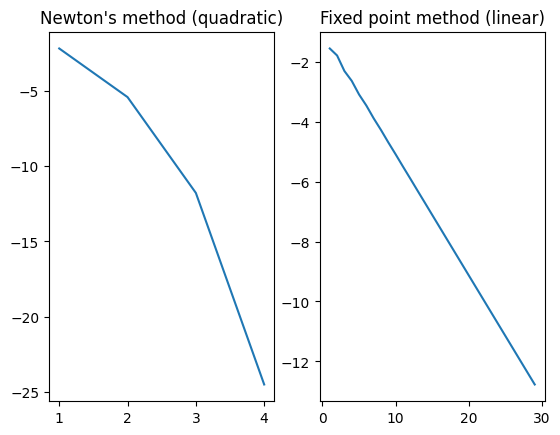

In [28]:
ns = list(range(1, 30))
fig, axes = plt.subplots(1, 2)
m1_results = [
    method_1_newton(1., n) for n in ns
]
m1_errs = [
    np.log(
        abs(exact_soln - e) or np.nan
    ) for e in m1_results
]

m2_results = [
    method_2_fixed_point(1., n) for n in ns
]
m2_errs = [
    np.log(
        abs(exact_soln - e) or np.nan
    ) for e in m2_results
]
axes[0].plot(ns, m1_errs)
axes[0].set_title("Newton's method (quadratic)")
axes[1].plot(ns, m2_errs)
_ = axes[1].set_title("Fixed point method (linear)")
